In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi")
cluster.start_cluster_sync()

Starting 14 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


<Cluster(cluster_id='1685472155-kudw', profile='default', controller=<running>, engine_sets=['1685472156'])>

In [17]:
"""
Homogeneous turbulence. See [1] for initialization and [2] for a section
on forcing the lowest wavenumbers to maintain a constant turbulent
kinetic energy.
[1] R. S. Rogallo, "Numerical experiments in homogeneous turbulence,"
NASA TM 81315 (1981)
[2] A. G. Lamorgese and D. A. Caughey and S. B. Pope, "Direct numerical simulation
of homogeneous turbulence with hyperviscosity", Physics of Fluids, 17, 1, 015106,
2005, (https://doi.org/10.1063/1.1833415)
"""
from __future__ import print_function
import warnings
import numpy as np
from numpy import pi, zeros, sum
from shenfun import Function
from shenfun.fourier import energy_fourier
from spectralDNS import config, get_solver, solve

try:
    import matplotlib.pyplot as plt

except ImportError:
    warnings.warn("matplotlib not installed")
    plt = None

def initialize(solver, context):
    c = context
    # Create mask with ones where |k| < Kf2 and zeros elsewhere
    kf = config.params.Kf2
    c.k2_mask = np.where(c.K2 <= kf**2, 1, 0)
    np.random.seed(solver.rank)
    k = np.sqrt(c.K2)
    k = np.where(k == 0, 1, k)
    kk = c.K2.copy()
    kk = np.where(kk == 0, 1, kk)
    k1, k2, k3 = c.K[0], c.K[1], c.K[2]
    ksq = np.sqrt(k1**2+k2**2)
    ksq = np.where(ksq == 0, 1, ksq)

    E0 = np.sqrt(9./11./kf*c.K2/kf**2)*c.k2_mask
    E1 = np.sqrt(9./11./kf*(k/kf)**(-5./3.))*(1-c.k2_mask)
    Ek = E0 + E1
    # theta1, theta2, phi, alpha and beta from [1]
    theta1, theta2, phi = np.random.sample(c.U_hat.shape)*2j*np.pi
    alpha = np.sqrt(Ek/4./np.pi/kk)*np.exp(1j*theta1)*np.cos(phi)
    beta = np.sqrt(Ek/4./np.pi/kk)*np.exp(1j*theta2)*np.sin(phi)
    c.U_hat[0] = (alpha*k*k2 + beta*k1*k3)/(k*ksq)
    c.U_hat[1] = (beta*k2*k3 - alpha*k*k1)/(k*ksq)
    c.U_hat[2] = beta*ksq/k
    c.mask = c.T.get_mask_nyquist()
    c.T.mask_nyquist(c.U_hat, c.mask)

    solver.get_velocity(**c)
    U_hat = solver.set_velocity(**c)

    K = c.K
    # project to zero divergence
    U_hat[:] -= (K[0]*U_hat[0]+K[1]*U_hat[1]+K[2]*U_hat[2])*c.K_over_K2

    if solver.rank == 0:
        c.U_hat[:, 0, 0, 0] = 0.0

    # Scale to get correct kinetic energy. Target from [2]
    energy = 0.5*energy_fourier(c.U_hat, c.T)
    target = config.params.Re_lam*(config.params.nu*config.params.kd)**2/np.sqrt(20./3.)
    c.U_hat *= np.sqrt(target/energy)

    if 'VV' in config.params.solver:
        c.W_hat = solver.cross2(c.W_hat, c.K, c.U_hat)

    config.params.t = 0.0
    config.params.tstep = 0
    c.target_energy = energy_fourier(c.U_hat, c.T)

def L2_norm(comm, u):
    r"""Compute the L2-norm of real array a
    Computing \int abs(u)**2 dx
    """
    N = config.params.N
    result = comm.allreduce(np.sum(u**2))
    return result/np.prod(N)

def spectrum(solver, context):
    c = context
    uiui = np.zeros(c.U_hat[0].shape)
    uiui[..., 1:-1] = 2*np.sum((c.U_hat[..., 1:-1]*np.conj(c.U_hat[..., 1:-1])).real, axis=0)
    uiui[..., 0] = np.sum((c.U_hat[..., 0]*np.conj(c.U_hat[..., 0])).real, axis=0)
    uiui[..., -1] = np.sum((c.U_hat[..., -1]*np.conj(c.U_hat[..., -1])).real, axis=0)
    uiui *= (4./3.*np.pi)

    # Create bins for Ek
    Nb = int(np.sqrt(sum((config.params.N/2)**2)/3))
    bins = np.array(range(0, Nb))+0.5
    z = np.digitize(np.sqrt(context.K2), bins, right=True)

    # Sample
    Ek = np.zeros(Nb)
    ll = np.zeros(Nb)
    for i, k in enumerate(bins[1:]):
        k0 = bins[i] # lower limit, k is upper
        ii = np.where((z > k0) & (z <= k))
        ll[i] = len(ii[0])
        Ek[i] = (k**3 - k0**3)*np.sum(uiui[ii])

    Ek = solver.comm.allreduce(Ek)
    ll = solver.comm.allreduce(ll)
    for i in range(Nb):
        if not ll[i] == 0:
            Ek[i] = Ek[i] / ll[i]

    E0 = uiui.mean(axis=(1, 2))
    E1 = uiui.mean(axis=(0, 2))
    E2 = uiui.mean(axis=(0, 1))

    ## Rij
    #for i in range(3):
    #    c.U[i] = c.FFT.ifftn(c.U_hat[i], c.U[i])
    #X = c.FFT.get_local_mesh()
    #R = np.sqrt(X[0]**2 + X[1]**2 + X[2]**2)
    ## Sample
    #Rii = np.zeros_like(c.U)
    #Rii[0] = c.FFT.ifftn(np.conj(c.U_hat[0])*c.U_hat[0], Rii[0])
    #Rii[1] = c.FFT.ifftn(np.conj(c.U_hat[1])*c.U_hat[1], Rii[1])
    #Rii[2] = c.FFT.ifftn(np.conj(c.U_hat[2])*c.U_hat[2], Rii[2])

    #R11 = np.sum(Rii[:, :, 0, 0] + Rii[:, 0, :, 0] + Rii[:, 0, 0, :], axis=0)/3

    #Nr = 20
    #rbins = np.linspace(0, 2*np.pi, Nr)
    #rz = np.digitize(R, rbins, right=True)
    #RR = np.zeros(Nr)
    #for i in range(Nr):
    #    ii = np.where(rz == i)
    #    RR[i] = np.sum(Rii[0][ii] + Rii[1][ii] + Rii[2][ii]) / len(ii[0])

    #Rxx = np.zeros((3, config.params.N[0]))
    #for i in range(config.params.N[0]):
    #    Rxx[0, i] = (c.U[0] * np.roll(c.U[0], -i, axis=0)).mean()
    #    Rxx[1, i] = (c.U[0] * np.roll(c.U[0], -i, axis=1)).mean()
    #    Rxx[2, i] = (c.U[0] * np.roll(c.U[0], -i, axis=2)).mean()

    return Ek, bins, E0, E1, E2

k = []
w = []
kold = zeros(1)
im1 = None
energy_new = None
def update(context):
    global k, w, im1, energy_new
    c = context
    params = config.params
    solver = config.solver
    curl_hat = Function(c.VT, buffer=c.work[(c.U_hat, 2, True)])

    if solver.rank == 0:
        c.U_hat[:, 0, 0, 0] = 0

    if params.solver == 'VV':
        c.U_hat = solver.cross2(c.U_hat, c.K_over_K2, c.W_hat)

    energy_new = energy_fourier(c.U_hat, c.T)
    energy_lower = energy_fourier(c.U_hat*c.k2_mask, c.T)
    energy_upper = energy_new - energy_lower

    alpha2 = (c.target_energy - energy_upper) /energy_lower
    alpha = np.sqrt(alpha2)

    #du = c.U_hat*c.k2_mask*(alpha)
    #dus = energy_fourier(du*c.U_hat, c.T)

    energy_old = energy_new

    #c.dU[:] = alpha*c.k2_mask*c.U_hat
    c.U_hat *= (alpha*c.k2_mask + (1-c.k2_mask))

    energy_new = energy_fourier(c.U_hat, c.T)

    assert np.sqrt((energy_new-c.target_energy)**2) < 1e-7, np.sqrt((energy_new-c.target_energy)**2)

    if params.solver == 'VV':
        c.W_hat = solver.cross2(c.W_hat, c.K, c.U_hat)

    if (params.tstep % params.compute_energy == 0 or
            params.tstep % params.plot_step == 0 and params.plot_step > 0):
        solver.get_velocity(**c)
        solver.get_curl(**c)
        if 'NS' in params.solver:
            solver.get_pressure(**c)

    K = c.K
    if plt is not None:
        if params.tstep % params.plot_step == 0 and solver.rank == 0 and params.plot_step > 0:
            #div_u = solver.get_divergence(**c)

            if not plt.fignum_exists(1):
                plt.figure(1)
                #im1 = plt.contourf(c.X[1][:,:,0], c.X[0][:,:,0], div_u[:,:,10], 100)
                im1 = plt.contourf(c.X[1][..., 0], c.X[0][..., 0], c.U[0, ..., 10], 100)
                plt.colorbar(im1)
                plt.draw()
            else:
                im1.ax.clear()
                #im1.ax.contourf(c.X[1][:,:,0], c.X[0][:,:,0], div_u[:,:,10], 100)
                im1.ax.contourf(c.X[1][..., 0], c.X[0][..., 0], c.U[0, ..., 10], 100)
                im1.autoscale()
            plt.pause(1e-6)

    if params.tstep % params.compute_spectrum == 0:
        Ek, _, _, _, _ = spectrum(solver, context)
        f = h5py.File(context.spectrumname, driver='mpio', comm=solver.comm, mode='a')
        f['Turbulence/Ek'].create_dataset(str(params.tstep), data=Ek)
        f.close()

    if params.tstep % params.compute_energy == 0:
        dx, L = params.dx, params.L
        #ww = solver.comm.reduce(sum(curl*curl)/np.prod(params.N)/2)

        duidxj = np.zeros(((3, 3)+c.U[0].shape), dtype=c.float)
        for i in range(3):
            for j in range(3):
                duidxj[i, j] = c.T.backward(1j*K[j]*c.U_hat[i], duidxj[i, j])

        ww2 = L2_norm(solver.comm, duidxj)*params.nu
        #ww2 = solver.comm.reduce(sum(duidxj*duidxj))

        ddU = np.zeros(((3,)+c.U[0].shape), dtype=c.float)
        dU = solver.ComputeRHS(c.dU, c.U_hat, solver, **c)
        for i in range(3):
            ddU[i] = c.T.backward(dU[i], ddU[i])

        ww3 = solver.comm.allreduce(sum(ddU*c.U))/np.prod(params.N)

        ##if solver.rank == 0:
            ##print('W ', params.nu*ww, params.nu*ww2, ww3, ww-ww2)
        curl_hat = solver.cross2(curl_hat, K, c.U_hat)
        dissipation = energy_fourier(curl_hat, c.T)
        div_u = solver.get_divergence(**c)
        #du = 1j*(c.K[0]*c.U_hat[0]+c.K[1]*c.U_hat[1]+c.K[2]*c.U_hat[2])
        div_u = L2_norm(solver.comm, div_u)
        #div_u2 = energy_fourier(solver.comm, 1j*(K[0]*c.U_hat[0]+K[1]*c.U_hat[1]+K[2]*c.U_hat[2]))

        kk = 0.5*energy_new
        eps = dissipation*params.nu
        Re_lam = np.sqrt(20*kk**2/(3*params.nu*eps))
        Re_lam2 = kk*np.sqrt(20./3.)/(params.nu*params.kd)**2

        kold[0] = energy_new
        e0, e1 = energy_new, L2_norm(solver.comm, c.U)
        ww4 = (energy_new-energy_old)/2/params.dt
        if solver.rank == 0:
            k.append(energy_new)
            w.append(dissipation)
            print('%2.4f %2.6e %2.6e %2.6e %2.6e %2.6e %2.6e %2.6e %2.6e'%(params.t, e0, e1, eps, ww2, ww3, ww4, Re_lam, Re_lam2))

    #if params.tstep % params.compute_energy == 1:
        #if 'NS' in params.solver:
            #kk2 = comm.reduce(sum(U.astype(float64)*U.astype(float64))*dx[0]*dx[1]*dx[2]/L[0]/L[1]/L[2]/2)
            #if rank == 0:
                #print 0.5*(kk2-kold[0])/params.dt

def init_from_file(filename, solver, context):
    f = h5py.File(filename, driver="mpio", comm=solver.comm)
    assert "0" in f["U/3D"]
    U_hat = context.U_hat
    s = context.T.local_slice(True)

    U_hat[:] = f["U/3D/0"][:, s[0], s[1], s[2]]
    if solver.rank == 0:
        U_hat[:, 0, 0, 0] = 0.0

    if 'VV' in config.params.solver:
        context.W_hat = solver.cross2(context.W_hat, context.K, context.U_hat)

    context.target_energy = energy_fourier(U_hat, context.T)

    f.close()


if __name__ == "__main__":
    import h5py
    config.update(
        {'nu': 0.005428,              # Viscosity (not used, see below)
         'dt': 0.002,                 # Time step
         'T': 5,                      # End time
         'L': [2.*pi, 2.*pi, 2.*pi],
         'checkpoint': 100,
         'write_result': 1e8,
         'dealias': '3/2-rule',
         'N': [60, 60, 60],
         'compute_energy': 100,
         'compute_spectrum': 1000,
         'plot_step': 10000,
         'Kf2': 3,
         'kd': 50.,
         'Re_lam': 84.,
         'optimization': 'cython',
         'write_result': 1000
        }, "triplyperiodic"
    )

    sol = get_solver(update=update, mesh="triplyperiodic", parse_args=["NS"])
    config.params.nu = (1./config.params.kd**(4./3.))

    context = sol.get_context()
    initialize(sol, context)
    #init_from_file("NS_isotropic_60_60_60_c.h5", sol, context)
    context.hdf5file.filename = "NS_isotropic_{}_{}_{}".format(*config.params.N)

    Ek, bins, E0, E1, E2 = spectrum(sol, context)
    context.spectrumname = context.hdf5file.filename+".h5"
    f = h5py.File(context.spectrumname, mode='w', driver='mpio', comm=sol.comm)
    f.create_group("Turbulence")
    f["Turbulence"].create_group("Ek")
    bins = np.array(bins)
    f["Turbulence"].create_dataset("bins", data=bins)
    f.close()
    solve(sol, context)
    from mpi4py_fft import generate_xdmf
    if sol.rank == 0:
        generate_xdmf(context.hdf5file.filename+"_w.h5")

0.2000 4.794113e+00 4.794113e+00 3.669030e+00 3.669030e+00 -3.669030e+00 3.681857e+00 4.385344e+01 8.400000e+01
0.4000 4.794113e+00 4.794113e+00 2.004871e+00 2.004871e+00 -2.004871e+00 2.009544e+00 5.932477e+01 8.400000e+01
0.6000 4.794113e+00 4.794113e+00 1.402259e+00 1.402259e+00 -1.402259e+00 1.403908e+00 7.093576e+01 8.400000e+01
0.8000 4.794113e+00 4.794113e+00 1.195115e+00 1.195115e+00 -1.195115e+00 1.195590e+00 7.683770e+01 8.400000e+01
1.0000 4.794113e+00 4.794113e+00 1.135622e+00 1.135622e+00 -1.135622e+00 1.135694e+00 7.882469e+01 8.400000e+01
1.2000 4.794113e+00 4.794113e+00 1.129659e+00 1.129659e+00 -1.129659e+00 1.129579e+00 7.903249e+01 8.400000e+01
1.4000 4.794113e+00 4.794113e+00 1.134295e+00 1.134295e+00 -1.134295e+00 1.134192e+00 7.887081e+01 8.400000e+01
1.6000 4.794113e+00 4.794113e+00 1.149122e+00 1.149122e+00 -1.149122e+00 1.148949e+00 7.836031e+01 8.400000e+01
1.8000 4.794113e+00 4.794113e+00 1.176500e+00 1.176500e+00 -1.176500e+00 1.176333e+00 7.744321e+01 8.400

OSError: Unable to synchronously open file (file is already open for read-only)

In [4]:
f = h5py.File("NS_isotropic_60_60_60.h5")

In [5]:
turb = np.array(f['Turbulence']['Ek']["2000"])

In [6]:
f53 = lambda x: x**(-5/3)
xs = np.arange(1, 31)
k = 5
ys = k*f53(xs)

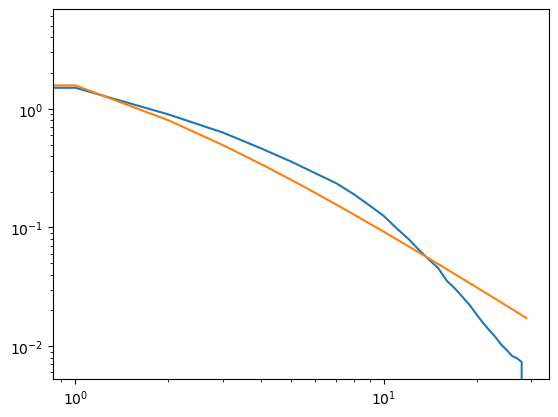

In [7]:
plt.plot(turb)
plt.plot(ys)
plt.xscale("log")
plt.yscale("log")

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [9]:
ys

array([5.        , 1.57490131, 0.80124976, 0.49606283, 0.34199519,
       0.25237786, 0.19519706, 0.15625   , 0.12840024, 0.10772173,
       0.0919    , 0.07949404, 0.06956612, 0.06148322, 0.05480471,
       0.04921567, 0.04448584, 0.04044354, 0.03695847, 0.03393022,
       0.03128032, 0.02894669, 0.02687965, 0.02503906, 0.02339214,
       0.02191195, 0.02057613, 0.019366  , 0.01826586, 0.0172624 ])

In [12]:
f = h5py.File("NS_isotropic_60_60_60_c.h5")

In [15]:
f["U"]["3D"]["0"]

<HDF5 dataset "0": shape (3, 60, 60, 31), type "<c16">